In [1]:
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial import Polynomial
import xarray as xr
import cartopy.crs as ccrs

import SeaLevelContrib as slc

import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
gam = pd.read_csv("/Users/sbult/Desktop/Scripts/data/tide gauges/output/Brest/results_NearestPointAverage2.csv")
gam.set_index("time", inplace=True)

obs_nod = gam["nod1"]+gam["nod2"]
obs_nod.name = "Observed cycle"

In [3]:
latitude_netherlands = 53
latitude_brest = 48
latitude_newlyn = 50
latitude_stavanger = 59
latitude_denmark = 54
latitude_cascais = 39
latitude_esbjerg = 55
latitude_bergen = 60
latitude_northshields = 55

In [4]:
def select_id(region):
    if region == 'Cascais':
        latitude = latitude_cascais
        tg_id = [52]
    elif region == 'Brest':
        latitude = latitude_brest
        tg_id = [1]
    elif region == 'Newlyn':
        latitude = latitude_newlyn
        tg_id = [202]
    elif region == 'Vlissingen':
        latitude = latitude_netherlands
        tg_id = [20]
    elif region == 'Hoek van Holland':
        latitude = latitude_netherlands
        tg_id = [22]
    elif region == 'IJmuiden':
        latitude = latitude_netherlands
        tg_id = [32]
    elif region == 'Den Helder':
        latitude = latitude_netherlands
        tg_id = [23]
    elif region == 'Harlingen':
        latitude = latitude_netherlands
        tg_id = [25]
    elif region == 'Delfzijl':
        latitude = latitude_netherlands
        tg_id = [24]
    elif region == 'Cuxhaven':
        latitude = latitude_denmark
        tg_id = [7]
    elif region == 'Esbjerg':
        latitude = latitude_esbjerg
        tg_id = [80]
    elif region == 'North Shields':
        latitude = latitude_northshields
        tg_id = [95]
    elif region == 'Stavanger':
        latitude = latitude_stavanger
        tg_id = [47]
    elif region == 'Bergen':
        latitude = latitude_bergen
        tg_id = [58]
    return tg_id, latitude

In [5]:
tg_id, lat = select_id('Brest')

In [6]:
h2 = 0.6032
k2 = 0.298

time_years = gam.index
    
period = np.array([15,16,17,18.6,20,21,22])
ampl = np.zeros(7)

for i in range(len(period)):
    A = 0.44*(1+k2-h2)*20*(3*np.sin(lat*np.pi/180.)**2-1)*1.20/10  # mm to cm
    nodcyc = A*np.cos((2*np.pi*(time_years-1922.7))/period[i] + np.pi)
    
    nodcyc_df = pd.DataFrame(data={'time': time_years, 'Nodal': nodcyc})
    nodcyc_df = nodcyc_df.set_index('time')
    
    et = nodcyc_df
    et = et.rename(columns={"Nodal":"Equilibrium tide"})
    
    nodal_df = et.join([obs_nod,res_nr["nodal_steric"]])
    nodal_df["Eq+Steric"] = nodal_df["Equilibrium tide"] + nodal_df["nodal_steric"]
    
    ampl[i] = nodal_df["nodal_steric"].loc[1993:2011].max()

NameError: name 'res_nr' is not defined

In [18]:
print(ampl)

[1.02998578 1.02998578 1.02998578 1.02998578 1.02998578 1.02998578
 1.02998578]


In [8]:
# Choose maximum depth of integration, region and start year for the analysis
max_depth = 400
region = "EBB"
start_year = 1960
end_year = 2020

In [9]:
StericSL_EBB_df = slc.StericSL('EN4_22', 'EBB', 0, max_depth, 0)
StericSL_BB_df = slc.StericSL('IAP', 'BB', 0, max_depth, 0)
StericSL_NWS_df = slc.StericSL('IAP', 'NWS', 0, max_depth, 0)
StericSL_ENS_df = slc.StericSL('IAP', 'ENS', 0, max_depth, 0)

StericSL_EBB_df.columns = ["Steric_EBB"]
StericSL_BB_df.columns = ["Steric_BB"]
StericSL_NWS_df.columns = ["Steric_NWS"]
StericSL_ENS_df.columns = ["Steric_ENS"]

StericSL_df = StericSL_EBB_df.join([StericSL_BB_df,StericSL_NWS_df,StericSL_ENS_df])

# Remove the first decades
StericSL_df = StericSL_df.loc[start_year:end_year]

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


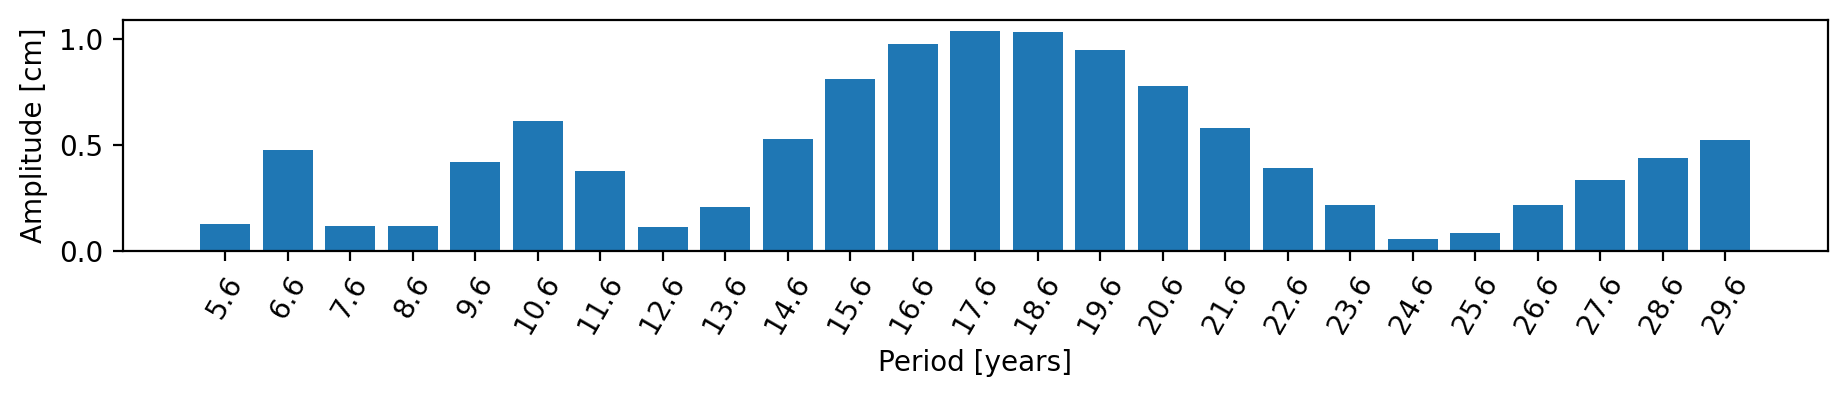

In [28]:
t = StericSL_df.index

reg_df = pd.DataFrame({'Steric':StericSL_df[f"Steric_{region}"]})

period = np.arange(5.6,30.6,1)

ampl = np.zeros(len(period))

for i in range(len(period)):
    reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/period[i])
    reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/period[i])
    
    res_nr, res_full_nr = compute_model(reg_df)
    
    ampl[i] = res_nr["nodal_steric"].loc[1993:2011].max()
    
fig, ax = plt.subplots(figsize=(11,1.5))
plt.bar(period,ampl);
plt.xticks(period,rotation=60)
plt.xlabel('Period [years]')
plt.ylabel('Amplitude [cm]');

#plt.savefig('/Users/sbult/Desktop/Scripts/data/tide gauges/figures/periods.png', dpi=150,bbox_inches='tight')

In [13]:
gam_df = len(t)//2
gam_alpha = 5000

In [14]:
def gam_model(reg_df, regression_formula, summary=False):

    bs_ts = BSplines(reg_df.index, df=gam_df, degree=3) 
    # alpha is the penalization weight for smooth terms
    gam_bs_ts = GLMGam.from_formula(regression_formula, data=reg_df, smoother=bs_ts, alpha=gam_alpha)
    res_gam = gam_bs_ts.fit()

    if summary:
        print(res_gam.summary())
        
    return res_gam

def store_results_df(reg_df, res_gam, reg_list):

    # Store model results in a dataframe
    model_results_df = pd.DataFrame(index=reg_df.index)

    for proc in reg_list: 
        model_results_df[proc] = reg_df[proc]*res_gam.params[proc]

    model_results_df['trend'] = res_gam.partial_values(0, True)[0]
    model_results_df['total'] = model_results_df.sum(axis=1)

    if 'nod1' in res_gam.params.index:
        model_results_df['nodal_steric'] = model_results_df['nod1'] + model_results_df['nod2']

    return model_results_df

def compute_model(reg_df):
    
    reg_list = ['nod1', 'nod2']
    regression_formula = 'Steric ~ nod1 + nod2'
    res_gam = gam_model(reg_df, regression_formula, summary=False)
    model_results_df = store_results_df(reg_df, res_gam, reg_list)
    
    return model_results_df, res_gam

In [15]:
res_nr, res_full_nr = compute_model(reg_df)

In [16]:
nodal_df = et.join([obs_nod,res_nr["nodal_steric"]])

nodal_df["Eq+Steric"] = nodal_df["Equilibrium tide"] + nodal_df["nodal_steric"]

In [17]:
print(nodal_df)

      Equilibrium tide  Observed cycle  nodal_steric  Eq+Steric
time                                                           
1890         -0.021550        0.577931           NaN        NaN
1891          0.139132        0.729409           NaN        NaN
1892          0.284105        0.798554           NaN        NaN
1893          0.397000        0.777562           NaN        NaN
1894          0.465068        0.668802           NaN        NaN
...                ...             ...           ...        ...
2017         -0.439613       -0.241610      0.219235  -0.220378
2018         -0.349409        0.025255      0.543558   0.194149
2019         -0.219754        0.289268      0.806527   0.586773
2020         -0.065285        0.520630      0.978459   0.913174
2021          0.096555        0.693226           NaN        NaN

[132 rows x 4 columns]


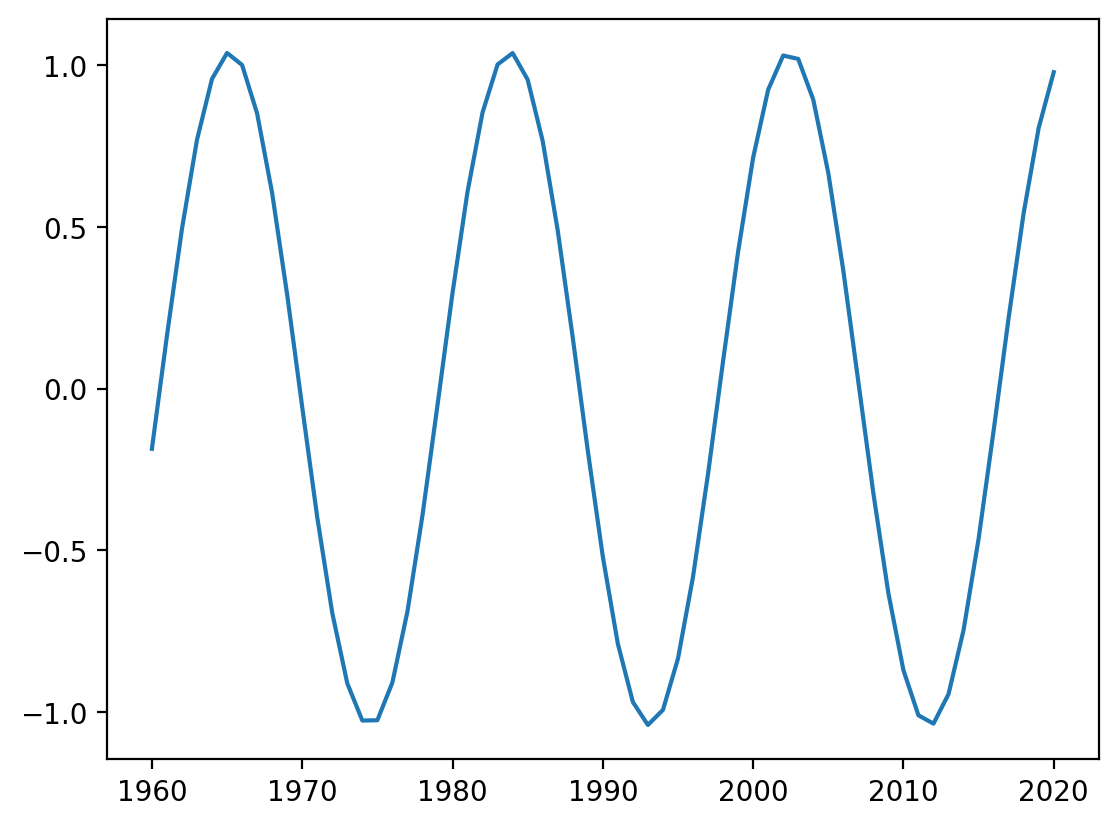

In [19]:
plt.plot(nodal_df['nodal_steric']);

In [21]:
ampl = nodal_df["nodal_steric"].loc[1993:2011].max()
print(ampl)

1.0299857833563681
